<style>
div.column {
  float: left;
  width: 33.33%;
  padding: 5px;
}
div.row::after {
  content: "";
  clear: both;
  display: table;
}
</style>

# Checkpointing in FEniCSx

## Jørgen Schartum Dokken

### Simula Research Laboratory

FEniCS 23'
 <div class="row">
  <div class="column">
    <img src="figures/fenics_banner.png" style="width:100%">
    </div>
  <div class="column">
   <img src="figures/logo.png" width="100%">
   </div>
</div> 


# Input/Output formats for Finite Element software

## FEM software
- Most finite element software use their own format for inputting/outputting meshes and functions
- No general consensus on what format to use

## Post-processing
- Most formats are based on [VTK](https://vtk.org/) in some shape or form
- Many different file formats support `vtk`
  - `.pvd`-files (`xml`-based)
  - `.xdmf`-files (`xml`+binary (`.h5`)
  - `.bp`-files (binary files in folder)

# What is checkpointing?

> Checkpointing refers to the ability to store the state of a computation in a way that allows it be continued at a later time without changing the computation’s behavior [1]

<div>
<p style="text-align:center;"><img src="figures/checkpointing.drawio.png" width="600">
</div>

[1] Schulz, M. (2011). Checkpointing. In: Padua, D. (eds) Encyclopedia of Parallel Computing. Springer, Boston, MA. [10.1007/978-0-387-09766-4_62](https://doi.org/10.1007/978-0-387-09766-4_62)

# Why separate post-processing and checkpointing?
The post-processing landscape keeps on changing
- Plain text formats are not scalable
- Formats go in and out of fashion
- Requirements for visualization and internal representation of data differs
<div>
<p style="text-align:center;"><img src="figures/N1curl.png" width="800">
     <figcaption>A basis function for Degree 1 Nédélec (first kind) on a triangle from  <a href="https://defelement.com/elements/examples/triangle-N1curl-1.html">DefElement.</a> </figcaption>
</div>


# Types of checkpointing

- _Snapshot checkpointing_
  - Only works while the program is running
  - FEniCS-setting: Mesh has to be the same

  - _Recoverable checkpointing_
    - Should work on any system
    - Any number of processes

# Implementing a snapshot checkpoint

Illustrated using [IPythonParallel](https://ipyparallel.readthedocs.io/en/latest/)

In [1]:
import ipyparallel as ipp
cluster = ipp.Cluster(engines="mpi", n=3, interactive=False)
rc = cluster.start_and_connect_sync()

Starting 3 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


In [2]:
%%px
from mpi4py import MPI
from dolfinx import mesh, fem
import adios2
from pathlib import Path
import numpy as np
print(f"{MPI.COMM_WORLD.rank=}, {MPI.COMM_WORLD.size=}")

[stdout:0] 
MPI.COMM_WORLD.rank=0, MPI.COMM_WORLD.size=3
[stdout:1] 
MPI.COMM_WORLD.rank=1, MPI.COMM_WORLD.size=3
[stdout:2] 
MPI.COMM_WORLD.rank=2, MPI.COMM_WORLD.size=3


# Implementing a snapshot checkpoint (write)

In [3]:
%%px

def snapshot_checkpoint_write(uh: fem.Function, file: Path):
    # Create ADIOS IO
    adios = adios2.ADIOS(uh.function_space.mesh.comm)
    io_name = "SnapshotCheckPoint"
    io = adios.DeclareIO(io_name)
    io.SetEngine("BP4")
    adios_file = io.Open(str(file), adios2.Mode.Write)

    dofmap = uh.function_space.dofmap
    num_dofs_local = dofmap.index_map.size_local * dofmap.index_map_bs

    # Extract local function data
    local_dofs = uh.x.array[:num_dofs_local].copy()

    # Write to file
    adios_file.BeginStep()
    dofs = io.DefineVariable("dofs", local_dofs, count=[num_dofs_local])
    adios_file.Put(dofs, local_dofs, adios2.Mode.Sync)
    adios_file.EndStep()
    adios.RemoveIO(io_name)

# Implementing a snapshot checkpoint (write)

In [4]:
%%px
domain = mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)
V = fem.FunctionSpace(domain, ("Lagrange", 5))
u = fem.Function(V)
u.interpolate(lambda x: x[0]**5 + 3*x[1]*x[0]**2)
scp_file = Path("u.bp")
snapshot_checkpoint_write(u, scp_file)

In [5]:
import subprocess
from pathlib import Path
scp_file = Path("u.bp")
_ = subprocess.run(["bpls", "-l", "-D", str(scp_file.absolute())])

  double   dofs  [3]*{__} = 2.99914e-53 / 4
        step 0: 
          block 0: [0:871] = 0.000425685 / 3.1
          block 1: [0:862] = 0.0866018 / 4
          block 2: [0:865] = 2.99914e-53 / 0.49024


# Implementing a snapshot checkpoint (read)

In [6]:
%%px
def snapshot_checkpoint_read(uh: fem.Function, file: Path):
    adios = adios2.ADIOS(uh.function_space.mesh.comm)
    io_name = "SnapshotCheckPoint"
    io = adios.DeclareIO(io_name)
    io.SetEngine("BP4")
    adios_file = io.Open(str(file), adios2.Mode.Read)

    dofmap = uh.function_space.dofmap
    num_dofs_local = dofmap.index_map.size_local * dofmap.index_map_bs

    adios_file.BeginStep()
    in_variable = io.InquireVariable("dofs")
    in_variable.SetBlockSelection(uh.function_space.mesh.comm.rank)
    adios_file.Get(in_variable, uh.x.array, adios2.Mode.Sync)
    adios_file.EndStep()
    uh.x.scatter_forward()
    adios.RemoveIO(io_name)

In [7]:
%%px
v = fem.Function(V)
snapshot_checkpoint_read(v, scp_file)
assert(np.allclose(u.x.array, v.x.array))

# ADIOS4DOLFINx is a package for checkpointing
- Implemented in Python with [ADIOS2](https://adios2.readthedocs.io/en/latest/) [2]
- Available at: [https://github.com/jorgensd/adios4dolfinx/](https://github.com/jorgensd/adios4dolfinx/)

## Features
- Snapshot checkpointing
- Recoverable checkpointing

In [8]:
%%px
import adios4dolfinx as adx
domain = mesh.create_unit_cube(MPI.COMM_WORLD, 10, 7, 3)
V = fem.FunctionSpace(domain, ("N1curl", 3))
u = fem.Function(V)
u.interpolate(lambda x: (x[0], x[1]*x[1], np.sin(x[2])))
cp_file = Path("u_curl.bp")
adx.snapshot_checkpoint(u, cp_file, adios2.Mode.Write)
v = fem.Function(V)
adx.snapshot_checkpoint(v, cp_file, adios2.Mode.Read)
assert np.allclose(v.x.array, u.x.array)

[stderr:0] 
  def find_first(b: int, a: npt.NDArray[np.int32]):

[stderr:1] 
  def find_first(b: int, a: npt.NDArray[np.int32]):

[stderr:2] 
  def find_first(b: int, a: npt.NDArray[np.int32]):



[2] W.F. Godoy, et al. _ADIOS 2: The Adaptable Input Output System. A framework for high-performance data management_, SoftwareX, Volume 12, 2020, [10.1016/j.softx.2020.100561](https://doi.org/10.1016/j.softx.2020.100561)

# How to do recoverable checkpointing?

Required information:
- `Mesh` (topology, geometry, base-element)
- `FunctionSpace` (dofmap)
- `Function` coefficient (dofs)

In [9]:
%%px
domain = mesh.create_unit_square(MPI.COMM_WORLD, 10, 10, mesh.CellType.quadrilateral)
V = fem.FunctionSpace(domain, ("NCE", 3))
u = fem.Function(V)
u.interpolate(lambda x: (x[0]**5, 3*x[1]*x[0]**2))
checkpoint_file = Path("function_checkpoint.bp")
adx.write_mesh(domain, checkpoint_file, engine="BP4")
adx.write_function(u, checkpoint_file, engine="BP4")

# Required data-structures

In [10]:
checkpoint_file = Path("function_checkpoint.bp")
_ = subprocess.run(["bpls", "-l", "-D", str(checkpoint_file.absolute())])

  uint32_t  CellPermutations  {100} = 0 / 12
        step 0: 
          block 0: [ 0:32] = 0 / 8
          block 1: [33:65] = 0 / 12
          block 2: [66:99] = 0 / 8
  int64_t   Dofmap            {2400} = 0 / 1859
        step 1: 
          block 0: [   0: 791] = 0 / 1373
          block 1: [ 792:1583] = 189 / 1520
          block 2: [1584:2399] = 504 / 1859
  double    Points            {121, 2} = 0 / 1
        step 0: 
          block 0: [  0: 39, 0:1] = 0 / 1
          block 1: [ 40: 80, 0:1] = 0 / 1
          block 2: [ 81:120, 0:1] = 0.3 / 1
  int64_t   Topology          {100, 4} = 0 / 120
        step 0: 
          block 0: [ 0:32, 0:3] = 0 / 93
          block 1: [33:65, 0:3] = 17 / 117
          block 2: [66:99, 0:3] = 38 / 120
  double    Values            {1860} = -0.165 / 0.285
        step 1: 
          block 0: [   0: 620] = -0.00945 / 0.025175
          block 1: [ 621:1232] = -0.105 / 0.135
          block 2: [1233:1859] = -0.165 / 0.285
  int64_t   XDofmap           {1

# Required data-structures

In [11]:
_ = subprocess.run(["bpls", str(checkpoint_file.absolute()), "-A", "-D", "-l"])

  string   CellType         attr   = "quadrilateral"
  int32_t  Degree           attr   = 1
  int32_t  LagrangeVariant  attr   = 1


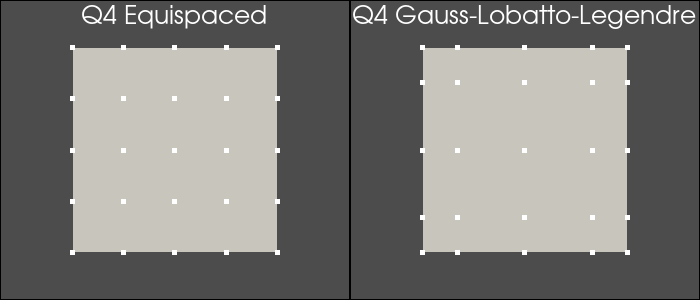

In [12]:
import dolfinx 
from mpi4py import MPI
import pyvista
import basix
mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 1, 1, cell_type=dolfinx.mesh.CellType.quadrilateral)
el_1 = basix.ufl.element(basix.ElementFamily.P, basix.CellType.quadrilateral, 4,
                               basix.LagrangeVariant.equispaced)
el_2 = basix.ufl.element(basix.ElementFamily.P, basix.CellType.quadrilateral, 4,
                               basix.LagrangeVariant.gll_warped)
V1 = dolfinx.fem.FunctionSpace(mesh, el_1)
V2 = dolfinx.fem.FunctionSpace(mesh, el_2)
grid_1 = pyvista.UnstructuredGrid(*dolfinx.plot.create_vtk_mesh(V1))
grid_2 = pyvista.UnstructuredGrid(*dolfinx.plot.create_vtk_mesh(V2))
pyvista.set_jupyter_backend("static")
pyvista.start_xvfb(1)
plotter = pyvista.Plotter(shape=(1, 2), window_size=(700,300))
plotter.add_text("Q4 Equispaced", position="upper_edge", font_size=10)
plotter.add_mesh(grid_1)
plotter.add_points(grid_1.points)
plotter.view_xy()
plotter.subplot(0, 1)
plotter.add_text("Q4 Gauss-Lobatto-Legendre", position="upper_edge", font_size=10)
plotter.add_mesh(grid_2)
plotter.add_points(grid_2.points)
plotter.view_xy()
plotter.show()

# Cell-permutations are used to consistently orient any finite element in parallel [3]

<div>
<p style="text-align:center;"><img src="figures/doforientation.png" width="600">
</div>


In [13]:
checkpoint_file = Path("function_checkpoint.bp")
_ = subprocess.run(["bpls", str(checkpoint_file.absolute()), "-la", "CellPermutations", "-D"])

  uint32_t  CellPermutations  {100} = 0 / 12
        step 0: 
          block 0: [ 0:32] = 0 / 8
          block 1: [33:65] = 0 / 12
          block 2: [66:99] = 0 / 8


[3] M.W. Scroggs, J.S. Dokken, C.N. Richardson, and G.N. Wells. 2022. _Construction of Arbitrary Order Finite Element Degree-of-Freedom Maps on Polygonal and Polyhedral Cell Meshes_ ACM Trans. Math. Softw. 48, 2, [10.1145/3524456](https://doi.org/10.1145/3524456)  

# The dofmap is needed to map the `Values` to the correct cell after partitioning

In [14]:
checkpoint_file = Path("function_checkpoint.bp")
_ = subprocess.run(["bpls", str(checkpoint_file.absolute()), "-la", "*Dof*", "-D"])

  int64_t   Dofmap            {2400} = 0 / 1859
        step 1: 
          block 0: [   0: 791] = 0 / 1373
          block 1: [ 792:1583] = 189 / 1520
          block 2: [1584:2399] = 504 / 1859
  int64_t   XDofmap           {101} = 0 / 2400
        step 1: 
          block 0: [  0: 33] = 0 / 792
          block 1: [ 33: 66] = 792 / 1584
          block 2: [ 66:100] = 1584 / 2400


# All communication is done using MPI neighbourhood communicators

- Avoids all `MPI_Alltoall` and `MPI_Alltoallv` communications
- Scales better with increasing number of processes [4]

[4] C. Richardson, G.N. Wells _Scalable MPI in FEniCS-dolfinx_  FEniCS 22'

# Further work
- Move implementation into C++ and DOLFINx
  - First step in [PR 2618](https://github.com/FEniCS/dolfinx/pull/2618)
- Add capability to store `MeshTags` in checkpointing files



# Summary
- A module for _snapshot_ and proper checkpoints for DOLFINx
- Works for any finite element in DOLFINx in serial and parallel
- Leverages ADIOS2 for parallel IO

<div class="row">
  <div class="column">
    <img src="figures/fenics_banner.png" style="width:100%">
    </div>
  <div class="column">
   <img src="figures/logo.png" width="100%">
   </div>
</div> 